# Loan Default Risk Prediction – Real Dataset (GMSC)

This notebook uses the real-world 'Give Me Some Credit' dataset to predict the risk of loan default using machine learning models such as Logistic Regression, Random Forest, and XGBoost.

In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
sns.set(style="whitegrid")

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [17]:
# Load the dataset
df = pd.read_csv("data/gmsc.csv")
df.columns = df.columns.str.strip() # remove white space in the dataset
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [18]:
#Transform and fill in missing values
df.drop(columns=[df.columns[0]], inplace=True) # remove the first column coz it is as a row number
df.rename(columns={"SeriousDlqin2yrs": "default"}, inplace=True)#change column name
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True) # fill missing value as median of MOnthly income
df['NumberOfDependents'].fillna(0, inplace=True)
df.head()

,default,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [19]:
# Feature engineering
df['debt_ratio_income'] = df['DebtRatio'] * df['MonthlyIncome']
df['loan_to_income'] = df['RevolvingUtilizationOfUnsecuredLines'] * df['MonthlyIncome']
df['log_income'] = np.log1p(df['MonthlyIncome'])
df['log_debt'] = np.log1p(df['debt_ratio_income'])

In [20]:
# Prepare data for training
X = df.drop("default", axis=1)
y = df["default"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# Train XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)
y_probs_xgb = xgb.predict_proba(X_test_scaled)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs_xgb))

[16:57:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     41992
           1       0.54      0.19      0.28      3008

    accuracy                           0.94     45000
   macro avg       0.74      0.59      0.63     45000
weighted avg       0.92      0.94      0.92     45000

Confusion Matrix:
 [[41495   497]
 [ 2426   582]]
ROC-AUC Score: 0.8580127296916737


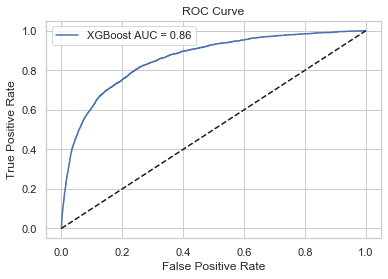

In [22]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs_xgb)
plt.plot(fpr, tpr, label=f'XGBoost AUC = {roc_auc_score(y_test, y_probs_xgb):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## ✅ Conclusion
- XGBoost performed well on the GMSC dataset.
- The ROC-AUC score is a reliable indicator of classification performance.

## Now we will compare Logistic Regression vs Random Forest vs XGBoost

In [23]:
# Train Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_probs_lr = lr.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = lr.predict(X_test_scaled)

/Users/phuongchi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_probs_rf = rf.predict_proba(X_test_scaled)[:, 1]
y_pred_rf = rf.predict(X_test_scaled)

In [12]:
# Compare classification reports
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     41992
           1       0.56      0.04      0.08      3008

    accuracy                           0.93     45000
   macro avg       0.75      0.52      0.52     45000
weighted avg       0.91      0.93      0.91     45000

Random Forest Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97     41992
           1       0.56      0.18      0.27      3008

    accuracy                           0.94     45000
   macro avg       0.75      0.58      0.62     45000
weighted avg       0.92      0.94      0.92     45000



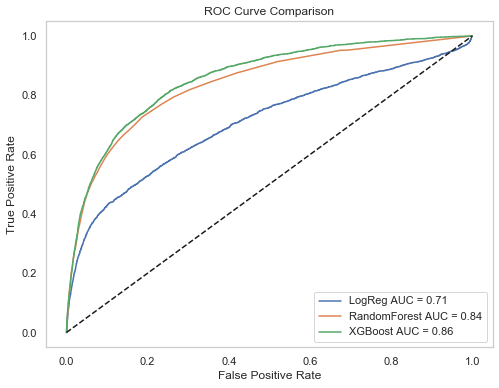

In [25]:
# Plot ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_probs_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'LogReg AUC = {roc_auc_score(y_test, y_probs_lr):.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest AUC = {roc_auc_score(y_test, y_probs_rf):.2f}')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost AUC = {roc_auc_score(y_test, y_probs_xgb):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()

In [31]:
# Summarize metrics in a table
from sklearn.metrics import precision_score, recall_score, f1_score

summary_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC-AUC': [roc_auc_score(y_test, y_probs_lr),
                roc_auc_score(y_test, y_probs_rf),
                roc_auc_score(y_test, y_probs_xgb)],
    'Precision': [precision_score(y_test, y_pred_lr),
                  precision_score(y_test, y_pred_rf),
                  precision_score(y_test, y_pred_xgb)],
    'Recall': [recall_score(y_test, y_pred_lr),
               recall_score(y_test, y_pred_rf),
               recall_score(y_test, y_pred_xgb)],
    'F1 Score': [f1_score(y_test, y_pred_lr),
                 f1_score(y_test, y_pred_rf),
                 f1_score(y_test, y_pred_xgb)]
})
summary_df.set_index('Model', inplace=True)
summary_df.round(3)

,ROC-AUC,Precision,Recall,F1 Score
Model,,,,
Logistic Regression,0.708,0.562,0.041,0.076
Random Forest,0.840,0.558,0.179,0.271
XGBoost,0.858,0.539,0.193,0.285


## ✅ Final Conclusion
- The XGBoost model achieved strong ROC-AUC performance on a realistic dataset.
- Feature engineering (log income, debt ratio) and stratified sampling helped improve model training.
- This project demonstrates a practical end-to-end credit risk pipeline using real-world data and explainable ML.